# Regularization of ANN weights


...to avoid overfitting 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

Load the [Auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg).

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']
data = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)


Check is there are missing entries in the dataset.

In [3]:
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    6
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
dtype: int64


Remove records with missing entries.

In [4]:
data = data.dropna()
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
dtype: int64


## Data inspection

Display some basic information.

In [5]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
18.0,8,307.0,130.0,3504.0,12.0,70,1
15.0,8,350.0,165.0,3693.0,11.5,70,1
18.0,8,318.0,150.0,3436.0,11.0,70,1
16.0,8,304.0,150.0,3433.0,12.0,70,1
17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 392 entries, 18.0 to 31.0
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    int64  
 1   Cylinders     392 non-null    float64
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    int64  
 6   Model Year    392 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 24.5 KB


In [7]:
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


We are interested in predicting the field `MPG`, measuring [fuel efficiency](https://en.wikipedia.org/wiki/Fuel_efficiency#:~:text=Fuel%20economy%20is%20the%20distance,a%20certain%20volume%20of%20fuel)), expressed in miles per gallon (MPG), where 1 MPG = 0.354006 km/L. Plot its distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


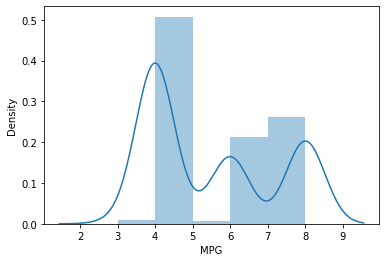

In [8]:
sns.distplot(data['MPG'])

Look for linear correlations among data.

In [9]:
data.corr()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
MPG,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
Cylinders,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
Displacement,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
Horsepower,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
Weight,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
Acceleration,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
Model Year,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


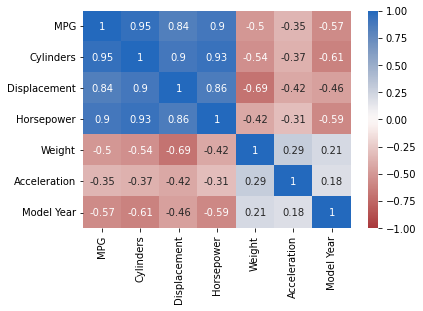

In [10]:
sns.heatmap(data.corr(), annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1)
#in blue there are shown good correlation

## Data normalization

Apply an affine transformation to the data, so that each feature has zero mean and unitary standard deviation.

In [33]:
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

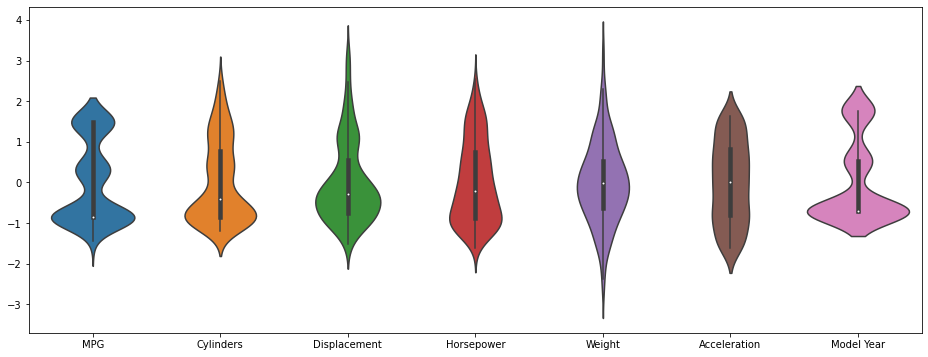

In [34]:
_, ax = plt.subplots(figsize=(16,6))
sns.violinplot(data = data_normalized, ax = ax)

## Train-validation split

Shuffle the data using the [np.random.shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) function and split the data as follows:
- put 80% in the train dataset
- put 20% in the validation dataset

In [35]:
data_normalized_np = data_normalized.to_numpy()
np.random.seed(0)
np.random.shuffle(data_normalized_np) 

fraction_validation = 0.2
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))
x_train = data_normalized_np[:num_train,1:]
y_train = data_normalized_np[:num_train,:1]
x_valid = data_normalized_np[num_train:,1:]
y_valid = data_normalized_np[num_train:,:1]

print('train set size     : %d' % x_train.shape[0])
print('validation set size: %d' % x_valid.shape[0])

train set size     : 313
validation set size: 79


## ANN setup

Write a function `params = initialize_params(layers_size)` that initializes the parameters, given the ANN architecture.
Initialize biases with zero values, and weights with a [Glorot Normal](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization, i.e. sampling from a Gaussian distribution with zero mean and with standard deviation 
$$
\sqrt{\frac{2}{n + m}},
$$
where $n$ and $m$ are the number of input and output neurons of the corresponding weights matrix.


In [36]:
def initialize_params(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    W = np.random.randn(layers_size[i+1], layers_size[i]) * np.sqrt(2 / (layers_size[i+1] + layers_size[i]))
    b = np.zeros((layers_size[i+1], 1))
    params.append(W)
    params.append(b)
  return params

Implement a generic feedforward ANN with a function `y = ANN(x, params)`, using $ReLU$ as activation function.

In [54]:
def ReLU(x):
  return jnp.maximum(0,x)

In [55]:
def ANN(x, params):
  num_layers = int(len(params)/2 + 1)
  weights = params[0::2]
  biases = params[1::2]
  layer = x.T
  for i in range(num_layers - 1):
    layer = weights[i] @ layer - biases[i]
    if i < num_layers - 2:
      layer = ReLU(layer)
  return layer.T


params = initialize_params([6, 10, 1])
ANN(x_train[:10,:], params) 

DeviceArray([[-1.2135705 ],
             [-1.1684033 ],
             [-1.5449598 ],
             [-1.7758018 ],
             [-0.96750164],
             [-0.88257587],
             [-1.2476346 ],
             [-1.3828882 ],
             [-0.5299725 ],
             [-0.32252   ]], dtype=float32)

Implement the quadratic loss (MSE) function `L = MSE(x, y, params)`.

In [56]:
def MSE(x, y, params):
  return jnp.mean((ANN(x,params)-y)**2)

params = initialize_params([6, 10, 1])
print(MSE(x_train, y_train, params))

2.9941356


Implement an $l^2$ regularization term for the ANN weights:
$$
\mathrm{MSW} = \frac{1}{n_{weights}} \sum_{i=1}^{n_{weights}} w_i^2
$$
and define the loss function as
$$
\mathcal{L} = \mathrm{MSE} + \beta \, \mathrm{MSW}
$$
where $\beta$ is a suitable penalization parameter.

In [57]:
def MSW(params):
  weights = params[0::2]
  squares_sum=0
  num_weights = 0
  for i in range(len(weights)):
    squares_sum += jnp.sum(weights[i]**2)
    num_weights += weights[i].shape[0] * weights[i].shape[1]
  return squares_sum / num_weights

def loss(x, y, params, penalization):
  return MSE(x,y,params) + penalization * MSW(params) 

print(MSW(params))
print(loss(x_train, y_train, params, 1.0))

0.14205272
3.1361883


Run this cell: we will this callback to monitor training.

In [66]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1, figsize=(16,8))
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs.clear()
      self.axs.loglog(history_loss_train, 'b-', label = 'loss train')
      self.axs.loglog(history_loss_valid, 'r-', label = 'loss validation')
      self.axs.loglog(history_MSE_train, 'b--', label = 'RMSE train')
      self.axs.loglog(history_MSE_valid, 'r--', label = 'RMSE validation')
      self.axs.legend()
      self.axs.set_title('epoch %d' % (self.epoch + 1))

## Training

Train an ANN with two hidden layers with 20 neurons each, using 2500 epochs of the SGD method (with minibatch size 100) with momentum ($\alpha = 0.9$).
Employ a linear decay of the learning rate:
$$
\lambda_k = \max\left(\lambda_\min, \lambda_\max \left(1 - \frac{k}{K}\right)\right)
$$
with $\lambda_\min = 1e-2$, $\lambda_\max = 1e-1$ and decay length $K= 1000$.

During training, store both the MSE error and the loss function obtained on the train and validation sets in 4 lists, respectively called:
- `history_loss_train`
- `history_loss_valid`
- `history_MSE_train`
- `history_MSE_valid`

Test different choices of the penalization parameter $\beta$.



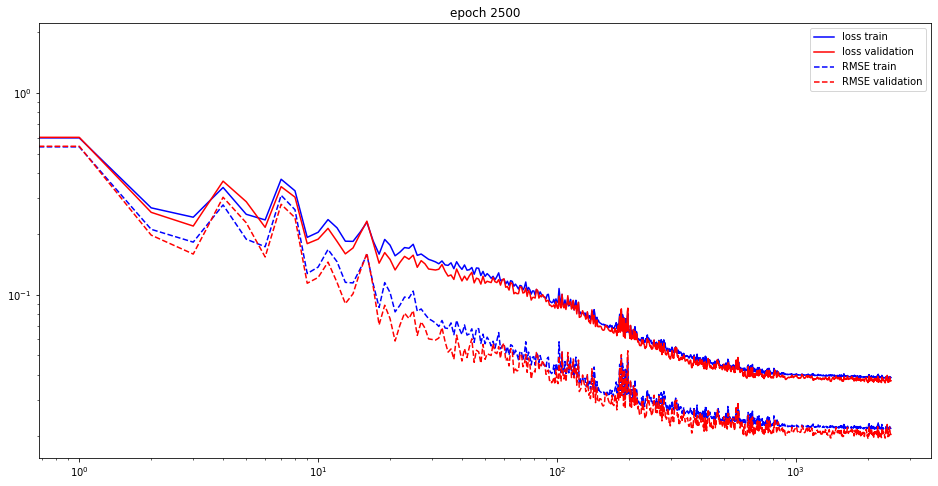

loss (train     ): 3.879e-02
loss (validation): 3.738e-02
MSE  (train     ): 2.182e-02
MSE  (validation): 2.041e-02


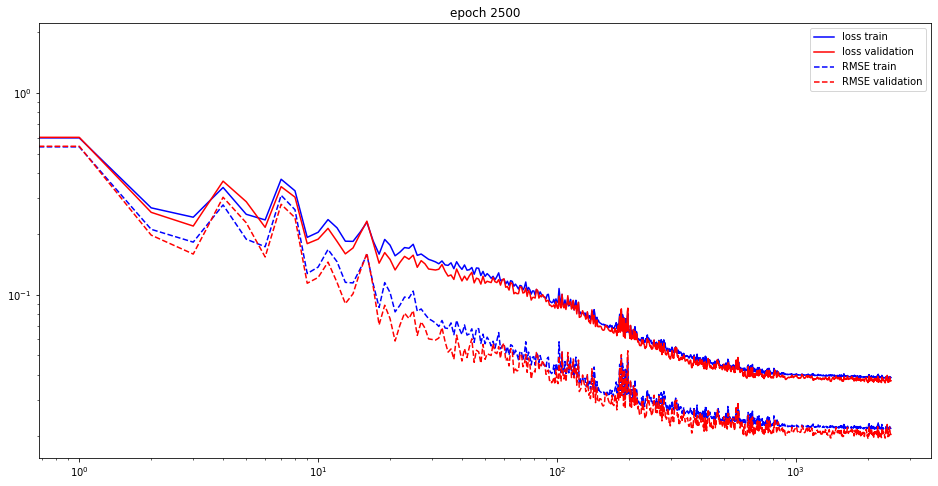

In [69]:
# Hyperparameters
layers_size = [6, 20, 20, 1]
penalization = 1.0
# Training options
num_epochs = 2500
learning_rate_max = 1e-1
learning_rate_min = 1e-2
learning_rate_decay = 1000
batch_size = 100
alpha = 0.9
########################################
num_train = x_train.shape[0]

grad_jit = jax.jit(jax.grad(loss, argnums = 2))
loss_jit = jax.jit(loss)
MSE_jit = jax.jit(MSE)

params = initialize_params(layers_size)

history_loss_train = list()
history_loss_valid = list()
history_MSE_train = list()
history_MSE_valid = list()

def append_losses():
  history_loss_train.append(loss_jit(x_train, y_train, params, penalization))
  history_loss_valid.append(loss_jit(x_valid, y_valid, params, penalization))
  history_MSE_train.append(MSE_jit(x_train, y_train, params))
  history_MSE_valid.append(MSE_jit(x_valid, y_valid, params))

append_losses()

velocity = [0.0 for i in range(len(params))]
cb = Callback()

for epoch in range(num_epochs):
  learning_rate = max(learning_rate_min, learning_rate_max*(1-epoch/learning_rate_decay))
  mini_batch = np.random.choice(num_train,batch_size)
  grads = grad_jit(x_train[mini_batch,:], y_train[mini_batch,:],params, penalization)
  for i in range(len(params)):
    velocity[i] = alpha * velocity[i] - learning_rate*grads[i]
    params[i] += velocity[i]

  append_losses()
  cb(epoch)

cb.draw()

print('loss (train     ): %1.3e' % history_loss_train[-1])
print('loss (validation): %1.3e' % history_loss_valid[-1])
print('MSE  (train     ): %1.3e' % history_MSE_train[-1])
print('MSE  (validation): %1.3e' % history_MSE_valid[-1])